# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
tf.random.set_seed(30)

In [3]:
# Mount the Google Drive
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
# import zipfile

# # Define the ZIP file path
# zip_file_path = '/content/gdrive/MyDrive/Project_data.zip'
# unzipped_folder = '/content/gdrive/MyDrive/Project_data'

# # Create the output folder if it doesn't exist
# os.makedirs(unzipped_folder, exist_ok=True)

# # Unzip the file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(unzipped_folder)
#     print("Files extracted successfully!")

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
if 'google.colab' in str(get_ipython()):
    root_path = '/content/gdrive/MyDrive/Project_data/Project_data/'
else:
    root_path = 'Project_data/Project_data/'

train_doc = np.random.permutation(open(root_path + 'train.csv').readlines())
val_doc = np.random.permutation(open(root_path + 'val.csv').readlines())
batch_size = 10 # experiment with the batch size

In [6]:
def count_images(folder_path):
    total_images = 0
    for root, dirs, files in os.walk(folder_path):
        total_images += len([file for file in files if file.lower().endswith(('jpg', 'jpeg', 'png'))])
    return total_images

train_image_count = count_images(root_path + 'train')
val_image_count = count_images(root_path + 'val')

print(f"Total images in train folder: {train_image_count}")
print(f"Total images in val folder: {val_image_count}")

Total images in train folder: 19890
Total images in val folder: 3000


#### Cropping function for Generator

In [7]:
def square_crop(image_array):
    # Get the dimensions of the image
    height, width = image_array.shape[:2]

    # Calculate the size of the square (the smaller dimension)
    new_size = min(width, height)

    # Calculate the cropping box (centered)
    left = (width - new_size) // 2
    top = (height - new_size) // 2
    right = (width + new_size) // 2
    bottom = (height + new_size) // 2

    # Crop the image to the square using NumPy array slicing
    cropped_image = image_array[top:bottom, left:right]

    return cropped_image

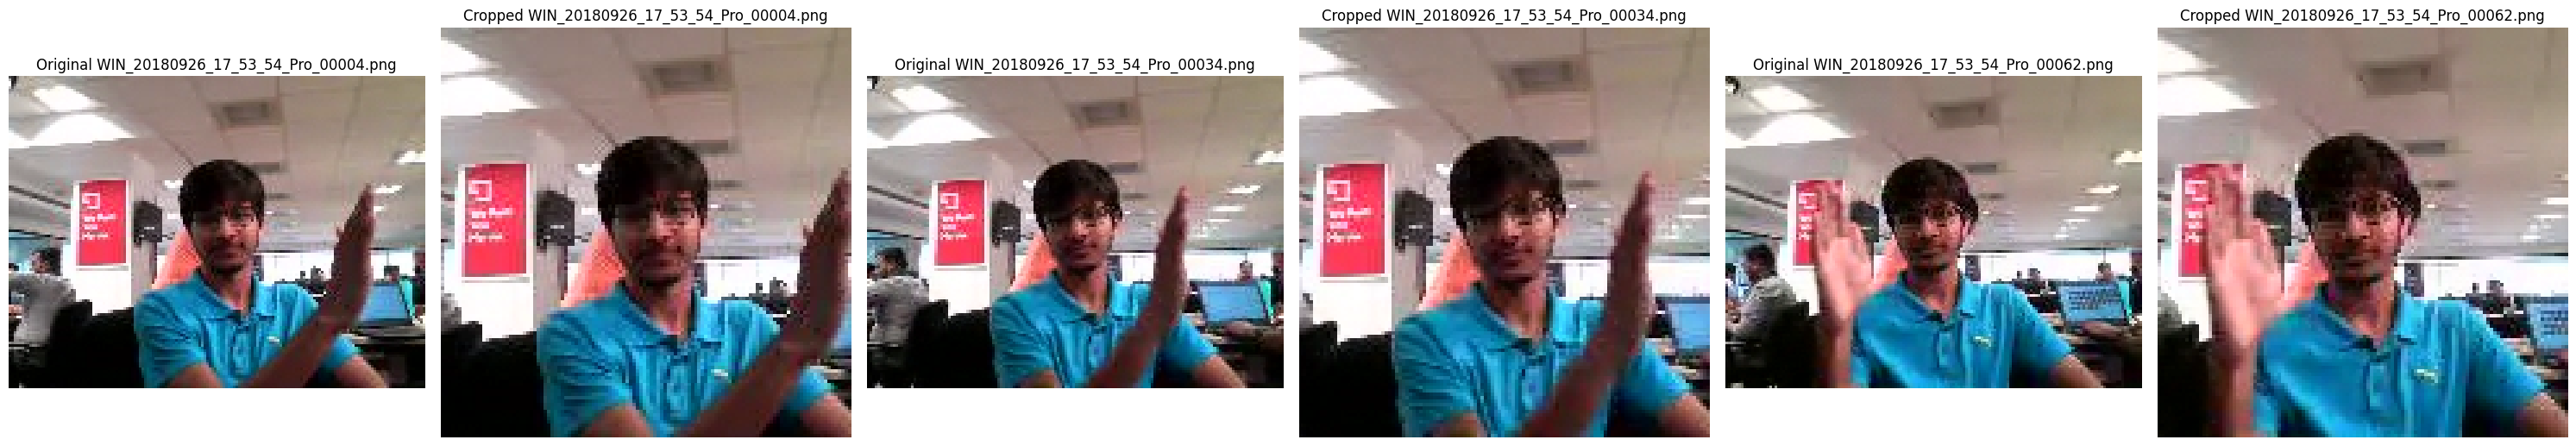

In [8]:
sample_images_dir = root_path + 'train/WIN_20180926_17_53_54_Pro_Right_Swipe_new'

# Get a list of all .png image files in the directory
image_files = [f for f in os.listdir(sample_images_dir) if f.endswith('.png')]

# Select the first, middle, and last images
num_images = len(image_files)
first_image = image_files[0]
middle_image = image_files[num_images // 2]
last_image = image_files[-1]

# Create a plot to display the images
plt.figure(figsize=(30, 10))

# List of selected image files (first, middle, last)
selected_images = [first_image, middle_image, last_image]

# Loop through and display each selected image
for idx, image_name in enumerate(selected_images):
    # Load the image using skimage
    image_path = os.path.join(sample_images_dir, image_name)
    image = imread(image_path)  # Reads the image as a NumPy array

    # Apply the square_crop function
    cropped_image = square_crop(image)

    # Plot the original and cropped image side by side (2 subplots per image)
    plt.subplot(2, 6, 2*idx + 1)
    plt.imshow(image)
    plt.title(f"Original {image_name}")
    plt.axis('off')

    plt.subplot(2, 6, 2*idx + 2)
    plt.imshow(cropped_image)
    plt.title(f"Cropped {image_name}")
    plt.axis('off')

# Tight layout for better fitting
plt.tight_layout()

# Show the plot
plt.show()

Cropped images have not lost the nature of the gesture. Looks good.

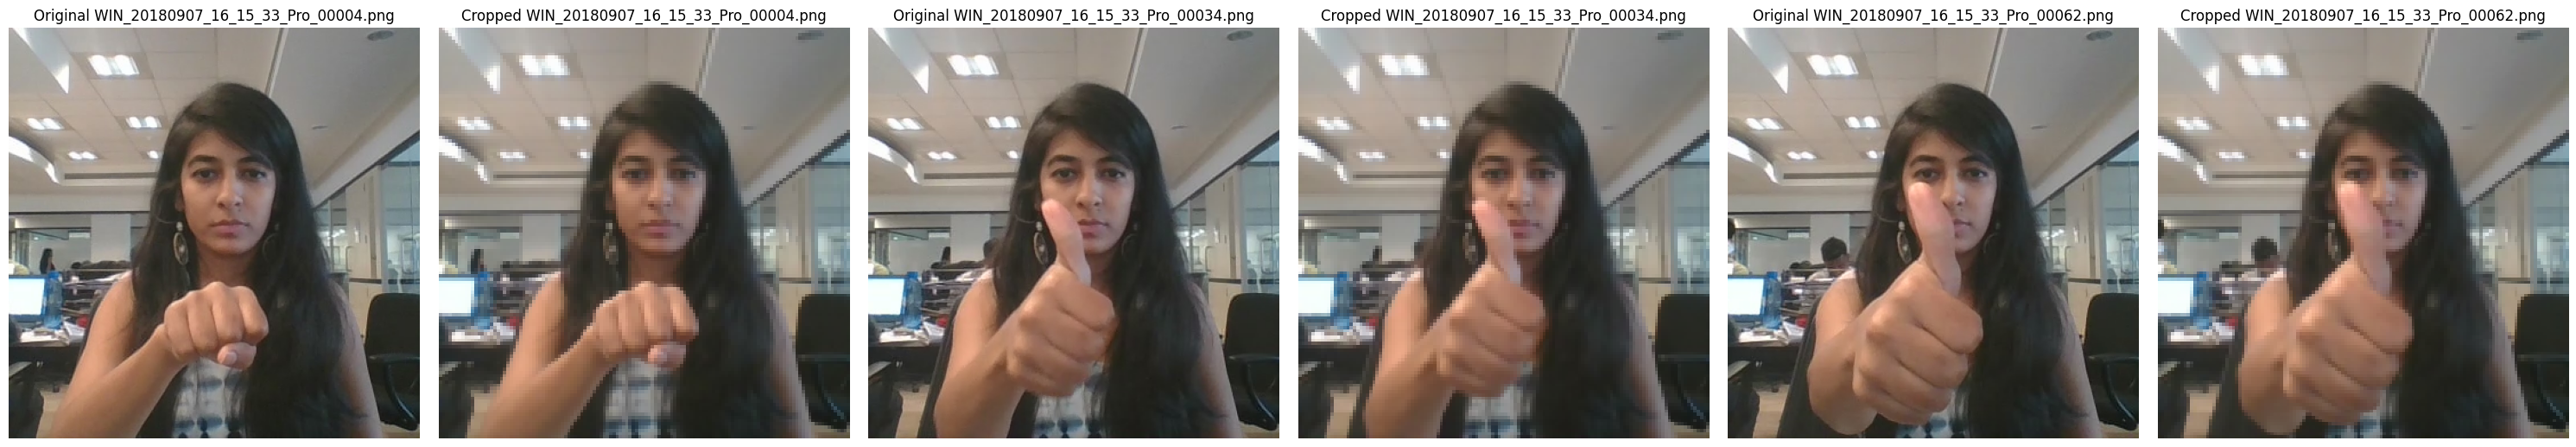

In [9]:
sample_images_dir = root_path + 'train/WIN_20180907_16_15_33_Pro_Thumbs Up_new'

# Get a list of all .png image files in the directory
image_files = [f for f in os.listdir(sample_images_dir) if f.endswith('.png')]

# Select the first, middle, and last images
num_images = len(image_files)
first_image = image_files[0]
middle_image = image_files[num_images // 2]
last_image = image_files[-1]

# Create a plot to display the images
plt.figure(figsize=(30, 10))

# List of selected image files (first, middle, last)
selected_images = [first_image, middle_image, last_image]

# Loop through and display each selected image
for idx, image_name in enumerate(selected_images):
    # Load the image using skimage
    image_path = os.path.join(sample_images_dir, image_name)
    image = imread(image_path)  # Reads the image as a NumPy array

    # Apply the resize function
    resized_image = resize(image, (128, 128))

    # Plot the original and cropped image side by side (2 subplots per image)
    plt.subplot(2, 6, 2*idx + 1)
    plt.imshow(image)
    plt.title(f"Original {image_name}")
    plt.axis('off')

    plt.subplot(2, 6, 2*idx + 2)
    plt.imshow(resized_image)
    plt.title(f"Cropped {image_name}")
    plt.axis('off')

# Tight layout for better fitting
plt.tight_layout()

# Show the plot
plt.show()

Resized Images have not lost much detail. Looks good.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
def generator(source_path, folder_list, batch_size, factor=1, img_size=128):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [k for k in range(0, 30, factor)]  # create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = img_size
    z = img_size

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes

                    # video images have two types of dimensions - either 360x360 or 120x160
                    # we must crop the images to 1:1 aspect ration and resize them to 120x120 dimensions or the specified dimensions

                    if image.shape[0] == 120:
                        # Image Crop
                        image = square_crop(image)

                    if image.shape[0] != img_size:
                        # Image Resize
                        image = resize(image, (img_size, img_size))


                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 # normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 # normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 # normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        remaining_data = len(t)%batch_size
        if (remaining_data) != 0:
            batch_data = np.zeros((remaining_data,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_data,5)) # batch_labels is the one hot representation of the output
            for folder in range(remaining_data): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx, item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes

                    # video images have two types of dimensions - either 360x360 or 120x160
                    # we must crop the images to 1:1 aspect ration and resize them to 120x120 dimensions or the specified dimensions

                    if image.shape[0] == 120:
                        # Image Crop
                        image = square_crop(image)

                    if image.shape[0] != img_size:
                        # Image Resize
                        image = resize(image, (img_size, img_size))


                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 # normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 # normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 # normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels # you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = root_path + 'train'
val_path = root_path + 'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


## Model #1 - Conv3D - 3 Convolutional Layers
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, Dense, LSTM, GRU
from keras.layers import Flatten, Dropout, TimeDistributed, BatchNormalization, GlobalAveragePooling2D, GlobalAveragePooling3D, Input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

#### Build the Model

In [13]:
img_size = 128
input_shape = (30, img_size, img_size, 3)
num_classes = 5

In [14]:
#write your model here

model1 = Sequential()

# Use the Input layer to define the input shape
model1.add(Input(shape=input_shape))

# First 3D Convolutional layer
model1.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second 3D Convolutional layer
model1.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third 3D Convolutional layer
model1.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model1.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten the 3D output for Dense layers
model1.add(Flatten())

# Fully connected (Dense) layers
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
model1.add(Dense(num_classes, activation='softmax'))  # num_classes for gesture categories

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 30, 128, 128,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 64, 64, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 64, 64, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 32, 32, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 7, 32, 32, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,362,757 (24.27 MB)

 Trainable params: 6,362,757 (24.27 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile the Model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:
optimiser = Adam(learning_rate=0.001) # write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#### Create the Generators

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size, img_size=img_size)
val_generator = generator(val_path, val_doc, batch_size, img_size=img_size)

In [17]:
# Fetch a single batch from train and validation generators
train_batch, train_labels = next(train_generator)
val_batch, val_labels = next(val_generator)

# Print shapes to verify
print("Train batch shape:", train_batch.shape)
print("Train labels shape:", train_labels.shape)
print("Validation batch shape:", val_batch.shape)
print("Validation labels shape:", val_labels.shape)

Source path =  Project_data/Project_data/train ; batch size = 10
Source path =  Project_data/Project_data/val ; batch size = 10
Train batch shape: (10, 30, 128, 128, 3)
Train labels shape: (10, 5)
Validation batch shape: (10, 30, 128, 128, 3)
Validation labels shape: (10, 5)


#### Set up Callbacks

In [18]:
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-1-conv3d-3-layers'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

#### Train the Model

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [20]:
history1 = model1.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.2069 - loss: 1.9877
Epoch 1: saving model to output_folder/model-1-conv3d-3-layers_2024-12-3106_57_11.181674/model-00001-1.67920-0.24585-1.41289-0.38000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 584s 9s/step - categorical_accuracy: 0.2075 - loss: 1.9831 - val_categorical_accuracy: 0.3800 - val_loss: 1.4129 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4208 - loss: 1.4524
Epoch 2: saving model to output_folder/model-1-conv3d-3-layers_2024-12-3106_57_11.181674/model-00002-1.37791-0.43288-1.14292-0.55000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 497s 8s/step - categorical_accuracy: 0.4210 - loss: 1.4513 - val_categorical_accuracy: 0.5500 - val_loss: 1.1429 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.5605 - loss: 1.0624
Epoch 3: saving model to output_folder/model-1-conv3d-3-layers_2024-12-3106_57_11.181674/model-00003-0.99096-

#### Visualize Training Results

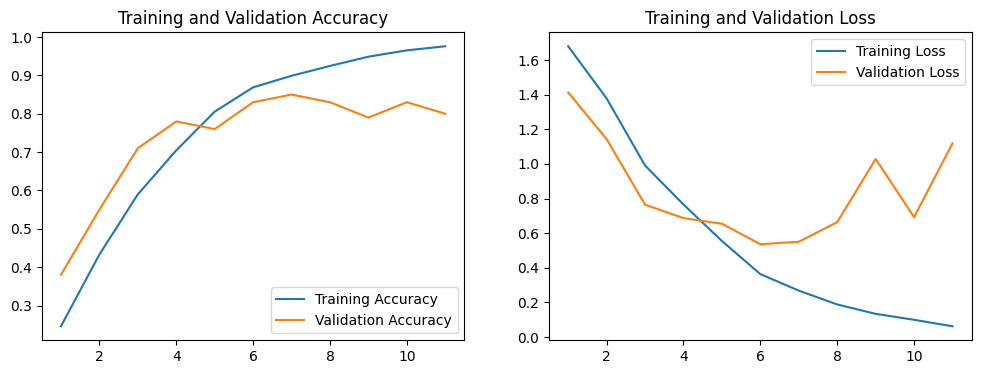

In [21]:
accuracy = history1.history['categorical_accuracy']
val_accuracy = history1.history['val_categorical_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(1, len(history1.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Findings

1. The Validation Accuracy has not improved beyond 8 epochs.
2. The Train Accuracy is very high as compared to Validation Accuracy beyond Epoch 7, implying **overfitting**.
3. Epoch 7 is the best model with Train Accuracy = ~ 90% and Validation Accuracy = ~ 85 %
4. The model initially shows a faster convergence with higher validation accuracy early on but as the no. of epochs increase the model shows a higher validation loss and a huge gap in train and validation accuracies.
5. The visualisation clearly highlights two major issues: firstly, Insufficient Learning of the General Trend and secondly, overfitting of the training data.

Let's try another model and see if we can improve the accuracy.

## Model #2 - Conv3D - 4 Convolutional Layers

There is a possiblity of overfitting when we increase the no. of layers so we must compensate it with dropout layers. Also instead of Flattening using GlobalAveragePooling to prevent overfitting.

In [22]:
# Build the Model

model2 = Sequential()

# Use the Input layer to define the input shape
model2.add(Input(shape=input_shape))

# First 3D Convolutional layer
model2.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second 3D Convolutional layer
model2.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third 3D Convolutional layer
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fourth 3D Convolutional layer
model2.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

# GlobalAveragePooling the 3D output for Dense layers
model2.add(GlobalAveragePooling3D())

# Fully connected (Dense) layers
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
model2.add(Dense(num_classes, activation='softmax'))  # num_classes for gesture categories

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 30, 128, 128,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 15, 64, 64, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 15, 64, 64, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 7, 32, 32, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 7, 32, 32, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 3, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 3, 16, 16, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 1, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 358,405 (1.37 MB)

 Trainable params: 358,405 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [24]:
# Set up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-2-conv3d-4-layers'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

In [25]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
# Train the model
history2 = model2.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.1959 - loss: 1.6242
Epoch 1: saving model to output_folder/model-2-conv3d-4-layers_2024-12-3106_57_11.181674/model-00001-1.61567-0.20060-1.60572-0.15000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 518s 8s/step - categorical_accuracy: 0.1960 - loss: 1.6240 - val_categorical_accuracy: 0.1500 - val_loss: 1.6057 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2414 - loss: 1.5673
Epoch 2: saving model to output_folder/model-2-conv3d-4-layers_2024-12-3106_57_11.181674/model-00002-1.51623-0.28507-1.40581-0.24000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 438s 7s/step - categorical_accuracy: 0.2420 - loss: 1.5665 - val_categorical_accuracy: 0.2400 - val_loss: 1.4058 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.3468 - loss: 1.4291
Epoch 3: saving model to output_folder/model-2-conv3d-4-layers_2024-12-3106_57_11.181674/model-00003-1.39419-

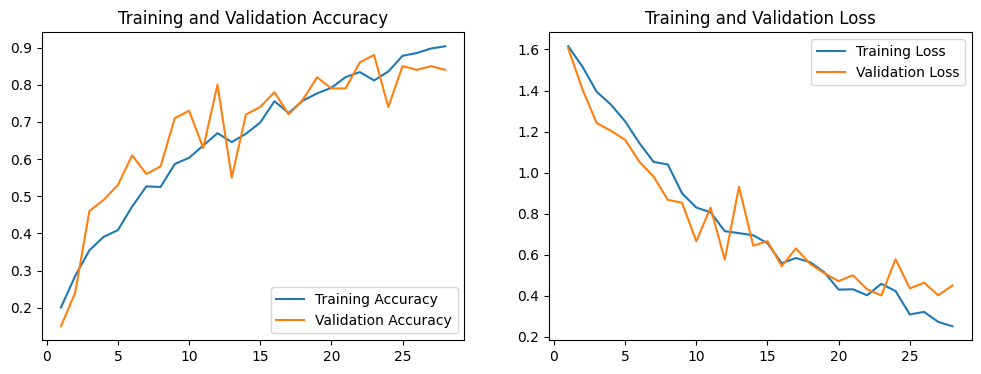

In [27]:
# Visualize the training results
accuracy = history2.history['categorical_accuracy']
val_accuracy = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(1, len(history2.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Findings

1. Validation Accuracy is moderately fluctuating though not deviating much from the train accuracy graph, implying a **good fitted** model.
2. The Validation Loss is not much fluctuating.
3. Epoch 23 is the best model with Train Accuracy = ~ 83% and Validation Accuracy = ~ 88%
4. Fluctuations in Validation Accuracy can be reduced by two methods, either by increasing the no. of 3D convolutional layers or by increasing the no. of neurons in the present architecture.

Let's try another model with more layers and see if we can improve the accuracy.

## Model #3 - Conv3D - 6 Convolutional Layers

For this model we shall include 6 3D Convolutional Layers distributed in 4 Blocks. We will also add two 25% dropout layers to account for Overfitting. We shall switch to Flatten instead of Global Average Pooling and see the difference in accuracy.

In [28]:
# Build the Model

model3 = Sequential()

# Use the Input layer to define the input shape
model3.add(Input(shape=input_shape))

# First Block
model3.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Block
model3.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Block
model3.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.25))

# Fourth Block
model3.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.25))

# Flatten the 3D output for Dense layers
model3.add(Flatten())

# Fully connected (Dense) layers
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
model3.add(Dense(num_classes, activation='softmax'))  # num_classes for gesture categories

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_7 (Conv3D)               │ (None, 30, 128, 128,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 15, 64, 64, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 15, 64, 64, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 7, 32, 32, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 7, 32, 32, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 7, 32, 32, 64)  │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 3, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 16, 16, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 3, 16, 16, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_12 (Conv3D)              │ (None, 3, 16, 16, 128) │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 1, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,975,941 (11.35 MB)

 Trainable params: 2,975,941 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [30]:
# Set up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-3-conv3d-6-layers'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

In [31]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [32]:
# Train the model
history3 = model3.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.1535 - loss: 1.6649
Epoch 1: saving model to output_folder/model-3-conv3d-6-layers_2024-12-3106_57_11.181674/model-00001-1.62520-0.16893-1.61058-0.19000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 600s 9s/step - categorical_accuracy: 0.1538 - loss: 1.6643 - val_categorical_accuracy: 0.1900 - val_loss: 1.6106 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.1865 - loss: 1.6105
Epoch 2: saving model to output_folder/model-3-conv3d-6-layers_2024-12-3106_57_11.181674/model-00002-1.61025-0.20513-1.61062-0.17000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 576s 9s/step - categorical_accuracy: 0.1868 - loss: 1.6105 - val_categorical_accuracy: 0.1700 - val_loss: 1.6106 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.1822 - loss: 1.6093
Epoch 3: saving model to output_folder/model-3-conv3d-6-layers_2024-12-3106_57_11.181674/model-00003-1.60928-

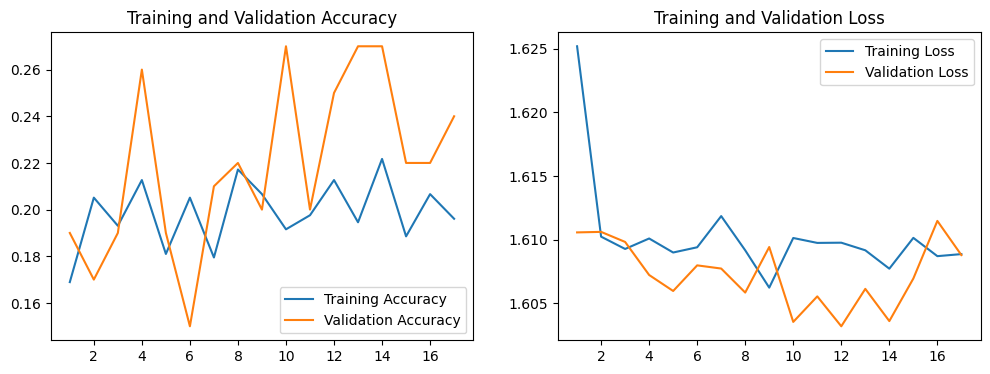

In [33]:
# Visualize the training results
accuracy = history3.history['categorical_accuracy']
val_accuracy = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(1, len(history3.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Findings

1. Increasing the no. of layers doesn't improve the accuracies. The accuracies are very low and the loss is also very high, implying the model is **underfitted** because the model is unable to learn the general patterns.
2. The Validation Accuracy and Validation Accuracy is fluctuating a lot.
3. Epoch 14 has Train acccuracy of 21% and Validation accuracy of 27%.

Let's try another model with 4 convolutional layers but more no. of neurons.

## Model #4 - Conv3D - 4 Convolutional Layers (Wider)

For this model we shall include 4 3D Convolutional Layers but double the no. of neurons in each layer. We shall switch back to Global Average Pooling and see the difference in accuracy.

In [34]:
# Build the Model

model4 = Sequential()

# Use the Input layer to define the input shape
model4.add(Input(shape=input_shape))

# First 3D Convolutional layer
model4.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second 3D Convolutional layer
model4.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third 3D Convolutional layer
model4.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fourth 3D Convolutional layer
model4.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

# GlobalAveragePooling the 3D output for Dense layers
model4.add(GlobalAveragePooling3D())

# Fully connected (Dense) layers
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer
model4.add(Dense(num_classes, activation='softmax'))  # num_classes for gesture categories

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_13 (Conv3D)              │ (None, 30, 128, 128,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 15, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_14 (Conv3D)              │ (None, 15, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 7, 32, 32, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_15 (Conv3D)              │ (None, 7, 32, 32, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 3, 16, 16, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_16 (Conv3D)              │ (None, 3, 16, 16, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 1, 8, 8, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,362,181 (5.20 MB)

 Trainable params: 1,362,181 (5.20 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [36]:
# Set up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-4-conv3d-4-layers-wider'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

In [37]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
# Train the model
history4 = model4.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.1862 - loss: 1.6702
Epoch 1: saving model to output_folder/model-4-conv3d-4-layers-wider_2024-12-3106_57_11.181674/model-00001-1.63031-0.18401-1.60962-0.20000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 548s 8s/step - categorical_accuracy: 0.1861 - loss: 1.6696 - val_categorical_accuracy: 0.2000 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2051 - loss: 1.6099
Epoch 2: saving model to output_folder/model-4-conv3d-4-layers-wider_2024-12-3106_57_11.181674/model-00002-1.61072-0.18250-1.60717-0.23000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 629s 9s/step - categorical_accuracy: 0.2048 - loss: 1.6099 - val_categorical_accuracy: 0.2300 - val_loss: 1.6072 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - categorical_accuracy: 0.1855 - loss: 1.6063
Epoch 3: saving model to output_folder/model-4-conv3d-4-layers-wider_2024-12-3106_57_11.181674/mo

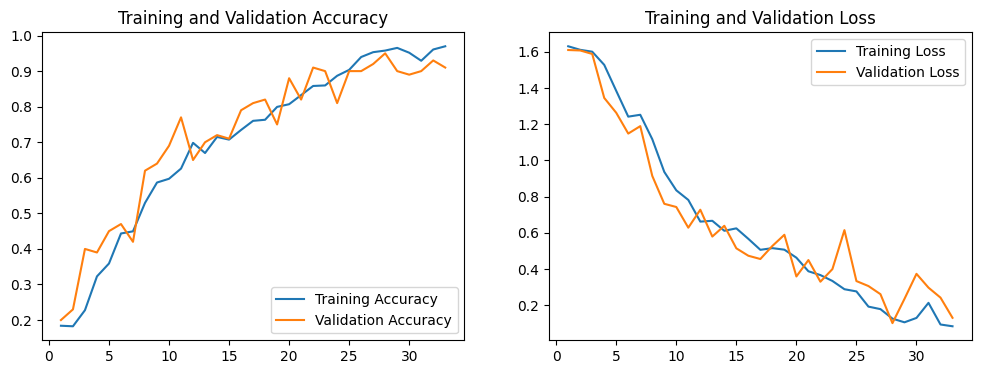

In [39]:
# Visualize the training results
accuracy = history4.history['categorical_accuracy']
val_accuracy = history4.history['val_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(1, len(history4.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Findings

1. Validation Accuracy is slightly fluctuating around the Train Accuracy graph, implying a **good fitted** model.
2. The Validation Loss is also low.
3. Epoch 28 is the best model with Train Accuracy = 96.5% and Validation Accuracy = 95%.
4. Increasing the no. of neurons has improved the accuracy by almost 7%

Now, Let's try another model with CNN-LSTM Architechture in order to improve accuracy even further.

## Model #5 - EfficientNetB0 (Image Net) + LSTM

In [40]:
img_size = 64
input_shape = (30, img_size, img_size, 3)
num_classes = 5

In [41]:
train_generator = generator(train_path, train_doc, batch_size, factor=2, img_size=img_size)
val_generator = generator(val_path, val_doc, batch_size, factor=2, img_size=img_size)

In [42]:
# Fetch a single batch from train and validation generators
train_batch, train_labels = next(train_generator)
val_batch, val_labels = next(val_generator)

# Print shapes to verify
print("Train batch shape:", train_batch.shape)
print("Train labels shape:", train_labels.shape)
print("Validation batch shape:", val_batch.shape)
print("Validation labels shape:", val_labels.shape)

Source path =  Project_data/Project_data/train ; batch size = 10
Source path =  Project_data/Project_data/val ; batch size = 10
Train batch shape: (10, 15, 64, 64, 3)
Train labels shape: (10, 5)
Validation batch shape: (10, 15, 64, 64, 3)
Validation labels shape: (10, 5)


#### Note: Please Ensure that you are connected to the internet to run the following code

In [43]:
# Download EfficientNetB0 architecture pre-trained on ImageNet
from tensorflow.keras.applications import EfficientNetB0

base_model_effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model_effnet.trainable = True

In [44]:
# write your model here

model5 = Sequential()

# Use the Input layer to define the input shape
model5.add(Input(shape=input_shape))

# TimeDistributed wrapper for EfficientNetB0
model5.add(TimeDistributed(base_model_effnet))

# Global Average Pooling layer to reduce dimensions
model5.add(TimeDistributed(GlobalAveragePooling2D()))

# LSTM layer to capture temporal dependencies
model5.add(LSTM(128, return_sequences=False))

# Fully connected layers
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model5.add(Dense(num_classes, activation='softmax'))

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 2, 2, 1280) │     4,049,571 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,788,136 (18.27 MB)

 Trainable params: 4,746,113 (18.10 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [45]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [46]:
# Set Up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-5-efficientnetb0-lstm'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

In [47]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [48]:
# Train the model
history5 = model5.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.4014 - loss: 1.4081
Epoch 1: saving model to output_folder/model-5-efficientnetb0-lstm_2024-12-3106_57_11.181674/model-00001-1.16322-0.53846-1.94728-0.20000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1046s 9s/step - categorical_accuracy: 0.4034 - loss: 1.4045 - val_categorical_accuracy: 0.2000 - val_loss: 1.9473 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.7823 - loss: 0.6852
Epoch 2: saving model to output_folder/model-5-efficientnetb0-lstm_2024-12-3106_57_11.181674/model-00002-0.66631-0.77828-3.19144-0.22000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 636s 10s/step - categorical_accuracy: 0.7822 - loss: 0.6849 - val_categorical_accuracy: 0.2200 - val_loss: 3.1914 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.7618 - loss: 0.7623
Epoch 3: saving model to output_folder/model-5-efficientnetb0-lstm_2024-12-3106_57_11.181674/model-

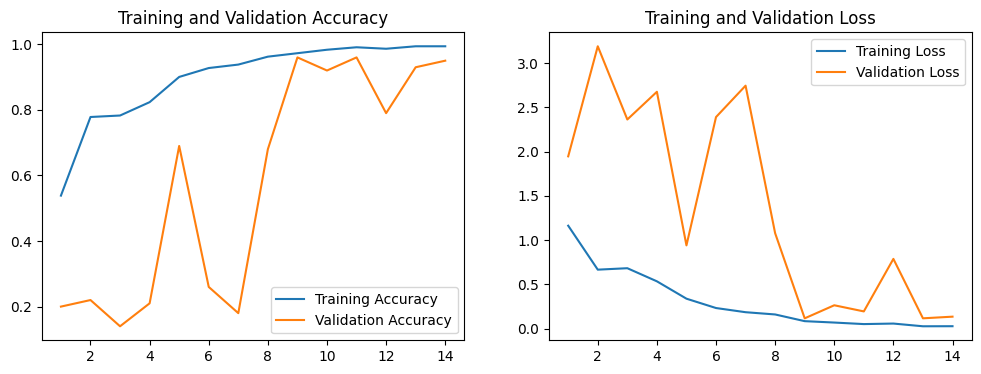

In [49]:
# Visualize the training results
accuracy = history5.history['categorical_accuracy']
val_accuracy = history5.history['val_categorical_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(1, len(history5.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Findings

1. Validation Accuracy is highly fluctuating around the Train Accuracy graph, implying a **slightly overfitted** model.
2. The Validation Loss is also fluctuating for the early epochs but is low for higher epochs.
3. Epoch 9 is the best model with Train Accuracy = 98% and Validation Accuracy = 96%.
4. Using EfficientNetB0 has not resulted in any stable model due to a higher no. of parameters hence we need to try another pre-trained model with lower no. of parameters.

Now, Let's try another model with CNN-LSTM Architechture in order to improve accuracy and stability even further.

## Model #6 - MobileNetV2 (Image Net) + LSTM

In [50]:
img_size = 96
input_shape = (30, img_size, img_size, 3)
num_classes = 5

In [51]:
train_generator = generator(train_path, train_doc, batch_size, factor=2, img_size=img_size)
val_generator = generator(val_path, val_doc, batch_size, factor=2, img_size=img_size)

In [52]:
# Fetch a single batch from train and validation generators
train_batch, train_labels = next(train_generator)
val_batch, val_labels = next(val_generator)

# Print shapes to verify
print("Train batch shape:", train_batch.shape)
print("Train labels shape:", train_labels.shape)
print("Validation batch shape:", val_batch.shape)
print("Validation labels shape:", val_labels.shape)

Source path =  Project_data/Project_data/train ; batch size = 10
Source path =  Project_data/Project_data/val ; batch size = 10
Train batch shape: (10, 15, 96, 96, 3)
Train labels shape: (10, 5)
Validation batch shape: (10, 15, 96, 96, 3)
Validation labels shape: (10, 5)


#### Note: Please Ensure that you are connected to the internet to run the following code

In [53]:
# Download MobileNet architecture pre-trained on ImageNet
from tensorflow.keras.applications import MobileNetV2

base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model_mobilenet.trainable = True

In [54]:
# write your model here

model6 = Sequential()

# Use the Input layer to define the input shape
model6.add(Input(shape=input_shape))

# TimeDistributed wrapper for MobileNetV2
model6.add(TimeDistributed(base_model_mobilenet))

# Global Average Pooling layer to reduce dimensions
model6.add(TimeDistributed(GlobalAveragePooling2D()))

# LSTM layer to capture temporal dependencies
model6.add(LSTM(128, return_sequences=False))

# Fully connected layers
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model6.add(Dense(num_classes, activation='softmax'))

model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, 30, 3, 3, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 30, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       721,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996,549 (11.43 MB)

 Trainable params: 2,962,437 (11.30 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [55]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [56]:
# Set Up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-6-mobilenetv2-lstm'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

In [57]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [58]:
# Train the model
history6 = model6.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - categorical_accuracy: 0.4617 - loss: 1.3070 
Epoch 1: saving model to output_folder/model-6-mobilenetv2-lstm_2024-12-3106_57_11.181674/model-00001-1.06627-0.60784-1.58440-0.43000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1490s 18s/step - categorical_accuracy: 0.4639 - loss: 1.3035 - val_categorical_accuracy: 0.4300 - val_loss: 1.5844 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - categorical_accuracy: 0.7787 - loss: 0.6736 
Epoch 2: saving model to output_folder/model-6-mobilenetv2-lstm_2024-12-3106_57_11.181674/model-00002-0.70816-0.76471-1.78441-0.44000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 1044s 16s/step - categorical_accuracy: 0.7785 - loss: 0.6741 - val_categorical_accuracy: 0.4400 - val_loss: 1.7844 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - categorical_accuracy: 0.8040 - loss: 0.6672 
Epoch 3: saving model to output_folder/model-6-mobilenetv2-lstm_2024-12-3106_57_11.181674/model-0

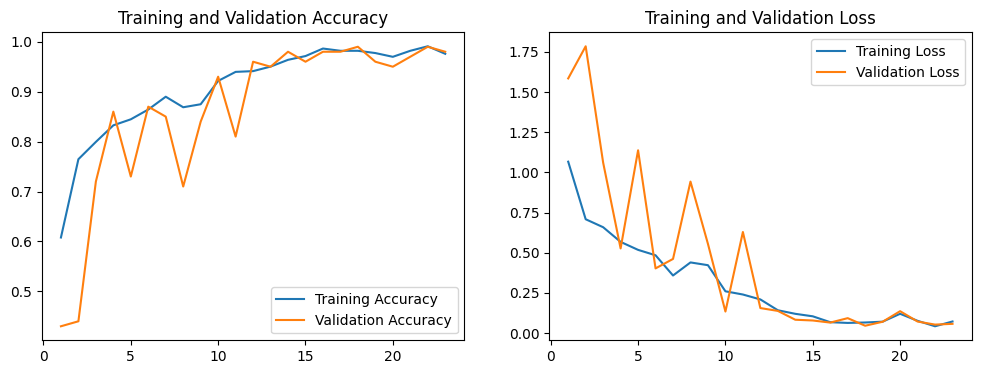

In [59]:
# Visualize the training results
accuracy = history6.history['categorical_accuracy']
val_accuracy = history6.history['val_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(1, len(history6.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Findings

1. Validation Accuracy is highly fluctuating for early epochs but as the no. of epochs increase the fluctuations subside significantly, implying a **well-fitted** model.
2. The Validation Loss also shows a similar trend as the validation accuracy graph.
3. Epoch 22 is the best model with Train Accuracy = 99% and Validation Accuracy = 99%. This is a good accuracy for the project.
4. Using MobileNetV2 has resulted in a very stable model due to an adequate no. of parameters. LSTM has more no. of parameters as compared to GRU, so lets try to build a similar model but with GRU in order to reduce the no. of parameters.

Now, Let's try another model with CNN-LSTM Architechture in order to reduce the no. of parameters even further.

## Model #7 - MobileNetV2 (Image Net) + GRU

In [13]:
img_size = 96
input_shape = (30, img_size, img_size, 3)
num_classes = 5

In [14]:
train_generator = generator(train_path, train_doc, batch_size, factor=2, img_size=img_size)
val_generator = generator(val_path, val_doc, batch_size, factor=2, img_size=img_size)

In [15]:
# Fetch a single batch from train and validation generators
train_batch, train_labels = next(train_generator)
val_batch, val_labels = next(val_generator)

# Print shapes to verify
print("Train batch shape:", train_batch.shape)
print("Train labels shape:", train_labels.shape)
print("Validation batch shape:", val_batch.shape)
print("Validation labels shape:", val_labels.shape)

Source path =  Project_data/Project_data/train ; batch size = 10
Source path =  Project_data/Project_data/val ; batch size = 10
Train batch shape: (10, 15, 96, 96, 3)
Train labels shape: (10, 5)
Validation batch shape: (10, 15, 96, 96, 3)
Validation labels shape: (10, 5)


#### Note: Please Ensure that you are connected to the internet to run the following code

In [16]:
# Download MobileNet architecture pre-trained on ImageNet
from tensorflow.keras.applications import MobileNetV2

base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model_mobilenet.trainable = True

In [17]:
# write your model here

model7 = Sequential()

# Use the Input layer to define the input shape
model7.add(Input(shape=input_shape))

# TimeDistributed wrapper for MobileNetV2
model7.add(TimeDistributed(base_model_mobilenet))

# Global Average Pooling layer to reduce dimensions
model7.add(TimeDistributed(GlobalAveragePooling2D()))

# GRU layer to capture temporal dependencies
model7.add(GRU(128, return_sequences=False))

# Fully connected layers
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.5))  # Dropout for regularization

# Output layer
model7.add(Dense(num_classes, activation='softmax'))

model7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 3, 3, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │       541,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,816,581 (10.74 MB)

 Trainable params: 2,782,469 (10.61 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [18]:
# Compile the model
optimiser = Adam(learning_rate=0.001) # write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [19]:
# Set Up Callbacks
if 'google.colab' in str(get_ipython()):
    output_folder = '/content/gdrive/MyDrive/output_folder'
else:
    output_folder = 'output_folder'

os.makedirs(output_folder, exist_ok=True)

model_initials = 'model-7-mobilenet-gru'

model_name = output_folder + '/' + model_initials + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

# ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# EarlyStopping
ES = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Reduce learning rate when the validation loss plateaus
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1) # write the ReduceLROnPlateau code here

callbacks_list = [checkpoint, ES, LR]

In [20]:
# Train Parameters
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
# Train the model
history7 = model7.fit(train_generator,
          validation_data=val_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_steps=validation_steps,
          class_weight=None,
          initial_epoch=0)

Epoch 1/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.4463 - loss: 1.3405
Epoch 1: saving model to output_folder/model-7-mobilenet-gru_2025-01-0106_42_10.589879/model-00001-1.01607-0.60935-1.13243-0.58000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 745s 7s/step - categorical_accuracy: 0.4487 - loss: 1.3357 - val_categorical_accuracy: 0.5800 - val_loss: 1.1324 - learning_rate: 0.0010
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.7827 - loss: 0.7323
Epoch 2: saving model to output_folder/model-7-mobilenet-gru_2025-01-0106_42_10.589879/model-00002-0.72244-0.77074-0.93268-0.73000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 528s 8s/step - categorical_accuracy: 0.7825 - loss: 0.7321 - val_categorical_accuracy: 0.7300 - val_loss: 0.9327 - learning_rate: 0.0010
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - categorical_accuracy: 0.8612 - loss: 0.4605
Epoch 3: saving model to output_folder/model-7-mobilenet-gru_2025-01-0106_42_10.589879/model-00003-0.50342-0.8552

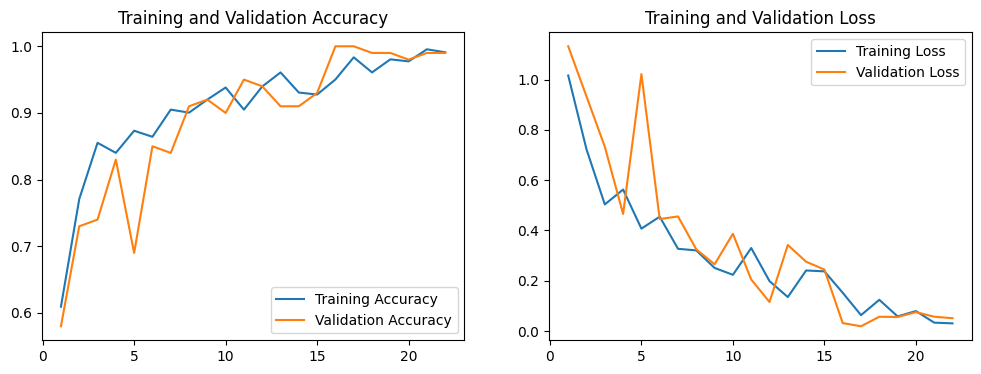

In [22]:
# Visualize the training results
accuracy = history7.history['categorical_accuracy']
val_accuracy = history7.history['val_categorical_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(1, len(history7.history['categorical_accuracy'])+1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### Findings

1. Validation Accuracy is moderately fluctuating for early epochs but as the no. of epochs increase the fluctuations subside significantly, implying a **well-fitted** model.
2. The Validation Loss also shows a similar trend as the validation accuracy graph.
3. Epoch 21 is the best model with Train Accuracy = 99% and Validation Accuracy = 99%. Even with a lesser no. of parameters we got a good accuracy.
4. Using MobileNetV2 + GRU has resulted in a very stable model due to an adequate no. of parameters. 

Hence the final model is model-00021-0.03319-0.99548-0.05676-0.99000.keras

## FINAL MODEL - model-00021-0.03319-0.99548-0.05676-0.99000.keras

In [24]:
# Load model
model = keras.models.load_model('output_folder/model-7-mobilenet-gru_2025-01-0106_42_10.589879/model-00021-0.03319-0.99548-0.05676-0.99000.keras')

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 30, 3, 3, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │       541,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,381,521 (31.97 MB)

 Trainable params: 2,782,469 (10.61 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 5,564,940 (21.23 MB)